In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%pylab inline
%matplotlib inline

#get Data
Andritz_data = pd.read_csv('C:/Users/PfitznerD/Desktop/Studium/IP/NS-Tagessummen-112086.csv', sep = ';', parse_dates=True)
#Umrechnung terminunabhängige 24h Werte
Andritz_data['prc_d'] = Andritz_data['prc_d']*1.13

#Andritz_data

Populating the interactive namespace from numpy and matplotlib


C:\Users\PfitznerD\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
#check data
print(Andritz_data.tail())
print('\n Data Types:')
print(Andritz_data.dtypes)

                  Datum   prc_d
17162  27.12.2017 07:00  16.159
17163  28.12.2017 07:00   0.226
17164  29.12.2017 07:00   0.000
17165  30.12.2017 07:00   0.000
17166  31.12.2017 07:00   0.000

 Data Types:
Datum     object
prc_d    float64
dtype: object


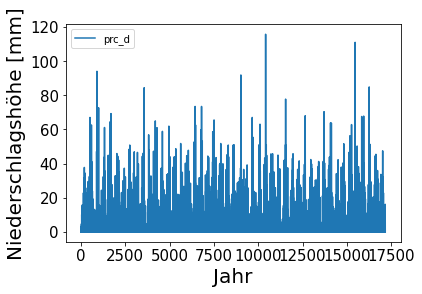

In [3]:
#plot tägliche NS-Werte
Andritz_data.plot(xlabel = 'Jahr', fontsize = 15, ylabel = 'Niederschlagshöhe [mm]')
plt.xlabel(xlabel = 'Jahr', fontsize = 20)
plt.ylabel('Niederschlagshöhe [mm]', fontsize = 20)
plt.savefig('NS_monatlich.png')


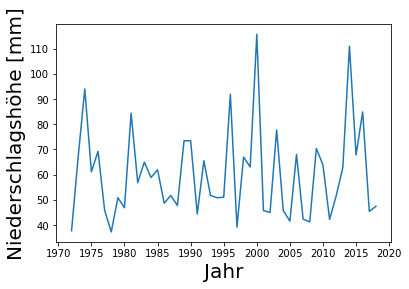

In [4]:
#plot jährliche Serie der NS-Maxima
Andritz_data.index = pd.to_datetime(Andritz_data['Datum'])

df = Andritz_data.groupby(pd.Grouper(freq="y")).prc_d.max()
#df = pd.DataFrame(y, columns=["X", "A", "B", "C"])

plt.plot(df)
plt.xlabel('Jahr', fontsize = 20)
plt.ylabel('Niederschlagshöhe [mm]', fontsize = 20)
plt.savefig('j-serie')

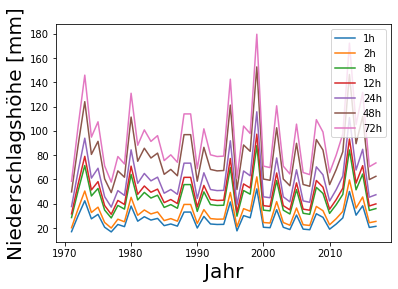

In [5]:
# zu untersuchende Dauerstufen
D = np.array([1, 2, 8, 12, 24, 48, 72])
D2 = np.array([60, 120, 480, 720, 1440, 2880, 4320])

#Umrechnung tägliche NS-Werte in Dauerstufen mittels Näherungsformeln
annualMax = pd.DataFrame(index=Andritz_data.index.year.unique())
pd.options.display.float_format = '{:,.2f}'.format

for d in D:            
    if d <= 24:
        n_d = Andritz_data['prc_d'] * (d / 24)**0.25
    else:
        n_d = Andritz_data['prc_d'] * (d / 24)**0.4
    annualMax[d] = n_d.groupby(n_d.index.year).max()

annualMax

#Erstelle Grafik 
df_new = annualMax.add_suffix('min')
df_new.index.names = ['Jahr']

df_new.columns=pd.MultiIndex.from_product([['Niederschlag[mm] je Dauerstufe'], ['1h', '2h', '8h', '12h', '24h', '48h', '72h']])
#'5min', '10min', '15min', '30min',
df_new
plt.plot(df_new)
plt.xlabel('Jahr', fontsize = 20)
plt.ylabel('Niederschlagshöhe [mm]', fontsize = 20)
plt.legend(['1h', '2h', '8h', '12h', '24h', '48h', '72h'], loc = 'upper right');
plt.savefig('jSerie-Dauerstufe')

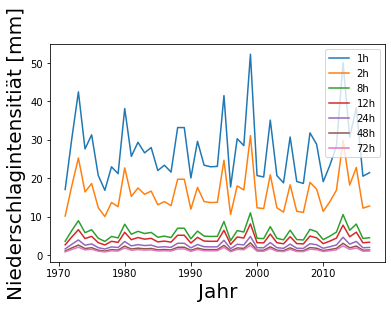

In [6]:
# zu untersuchende Dauerstufen in min
DS = np.array([60, 120, 480, 720, 1440, 2880, 4320])

#Umrechnung tägliche NSIntesitäts-Werte in Dauerstufen mittels Näherungsformeln
annualMaxa = pd.DataFrame(index=Andritz_data.index.year.unique())
pd.options.display.float_format = '{:,.2f}'.format

for i in DS:            
    if i <= 1440:
        int_d = Andritz_data['prc_d'] * (i / 1440)**0.25/i*60
    else:
        int_d = Andritz_data['prc_d'] * (i / 1440)**0.4/i*60
    
    annualMaxa[i] = int_d.groupby(int_d.index.year).max()

annualMaxa

df_news = annualMaxa.add_suffix('min')
df_news.index.names = ['Jahr']

df_news.columns=pd.MultiIndex.from_product([['Regenintensität I[mm/h] je Dauerstufe'], ['1h', '2h', '8h', '12h', '24h', '48h', '72h']])

plt.plot(df_news)
plt.xlabel('Jahr', fontsize = 20)
plt.ylabel('Niederschlagintensitiät [mm]', fontsize = 20)
plt.legend(['1h', '2h', '8h', '12h', '24h', '48h', '72h'], loc = 'upper right');



In [7]:
import lmoments3 as lm
lm.lmom_ratios(df)

[60.16408510638297,
 9.890061054579093,
 0.24310799193900706,
 0.13292951499521502,
 0.0921790378489417]

In [8]:
from lmoments3 import distr

#Anpassung Parameter der theoretischen Verteilungsfunktionen
paras = distr.gev.lmom_fit(df)
fitted_gev = distr.gev(**paras)

parasi = distr.pe3.lmom_fit(df)
fitted_pe3 = distr.pe3(**parasi)

#Berechnung Jährlichkeit nach Pearson3 oder GEV
T = np.arange(0.00001, 1000.0, 1.0)+1.0
Jährlichkeit = fitted_gev.ppf(1-1/T)
Jährlichkeit1 = fitted_pe3.ppf(1-1/2500)

#Jährlichkeit
Jährlichkeit1


170.98231397370898

In [9]:
#Mittelwert und Standardabweichung für empirische Verteilung
Mittelwert = df.mean()
STABW = df.std()
print (Mittelwert, STABW)

60.16408510638297 18.29041636061829


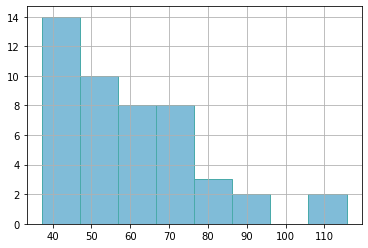

In [10]:
#absolute Häufigkeit empirisch
data = df[df>0].hist(bins=8, edgecolor='#4aaaaa', color='#80BCD8')

In [11]:
#Berechnung angepasste und ungepasste theoretische Verteilungen
NBereich = np.arange(20,145,0.1)
distnormal = stats.norm.pdf(NBereich, 
                            loc=Mittelwert, scale=STABW)
distlognormal1 = stats.pearson3.pdf(NBereich,skew=1,
                                   loc=Mittelwert, scale=STABW)
distweibull = stats.dweibull.pdf(NBereich,c=1,
                                   loc=Mittelwert, scale=STABW)
distchi2 = stats.chi2.pdf(NBereich,df=2,
                                   loc=Mittelwert, scale=STABW)
gev = stats.genextreme.pdf(NBereich,c=-0.11075177486598492,
                                   loc=51.253343718016865, scale=12.740797218611533)
gev1 = stats.genextreme.pdf(NBereich,c=-0.2121,
                                   loc=50.7974, scale=11.5985)

gumbel = stats.genextreme.pdf(NBereich,c=0,
                                   loc=Mittelwert, scale=STABW)
distlognormal = stats.pearson3.pdf(NBereich,skew=1.464578981137226,
                                   loc=60.16408510638298, scale=18.731024511582824)


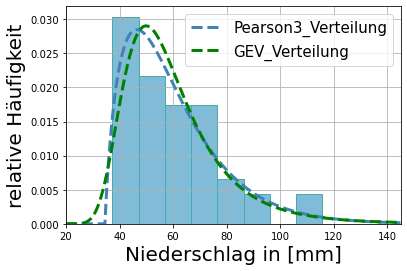

In [12]:
#plot histogramm
df.hist(bins=8, density=True, edgecolor='#4aaaaa', color='#80BCD8')
#plot(NBereich,Normalverteilung, color='#4B4C4E', linewidth=3, linestyle=':',label='Normalverteilung')
#plot(NBereich,Pearson3_Verteilung, color='#3F83B7', linewidth=3, linestyle='--', label='Pearson3_Verteilung')
plot(NBereich,distlognormal, color='#3F83B7', linewidth=3, linestyle='--', label='Pearson3_Verteilung')
#plot(NBereich,Weibull_Verteilung, color='#7B7C7E', linewidth=3, linestyle='-.', label='Weibull_Verteilung')
plot(NBereich,gev, color='green', linewidth=3, linestyle='--', label='GEV_Verteilung')
xlim(20,145)
legend(loc='upper right', fontsize = 15)
plt.xlabel('Niederschlag in [mm]', fontsize =20)
plt.ylabel('relative Häufigkeit', fontsize =20)
figsize(15,5)
#plt.savefig('relHist.png')

C:\Users\PfitznerD\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PfitznerD\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'relative Häufigkeit')

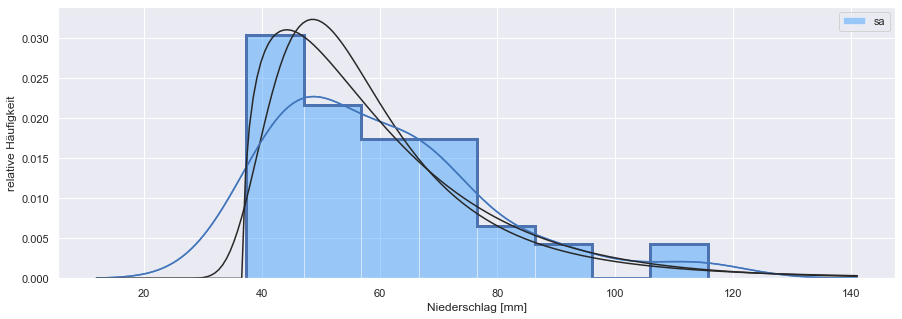

In [13]:
#Alternative Darstellung

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
from scipy.stats import genextreme
from scipy.stats import pearson3


int_24h = Andritz_data['prc_d'] * (1440 / 1440)**0.25
# series of annual maximum intensity for 2-h precipitation
annualMax_24h = int_24h.groupby(by=int_24h.index.year).max()
annualMax_24h
# visualize the data

#sns.distplot(annualMax_24h, bins=8, fit= pearson3, color='orange', label = 'ss')
sns.distplot(annualMax_24h, bins=8, fit= genextreme, color='dodgerblue', label = 'sa')

sns.distplot(annualMax_24h, bins = 8, fit = pearson3,
                  #fit_kws = {"color": "b"},
                  #kde_kws={"color": "r", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1})
legend()
plt.xlabel('Niederschlag [mm]')
plt.ylabel('relative Häufigkeit')

In [14]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF


# fit a GEV to the data
#parGEV_2h = genextreme.fit(annualMax_24h, f0=0)
parGEV_2h = pearson3.fit(annualMax_24h)

print('Fitted parameters for the intensity in 1h-duration storms:')
print('xi = {0:.4f}\nmu = {1:.4f}\nsigma = {2:.4f}'.format(*parGEV_2h))

Fitted parameters for the intensity in 1h-duration storms:
xi = 1.6512
mu = 60.1642
sigma = 19.3232


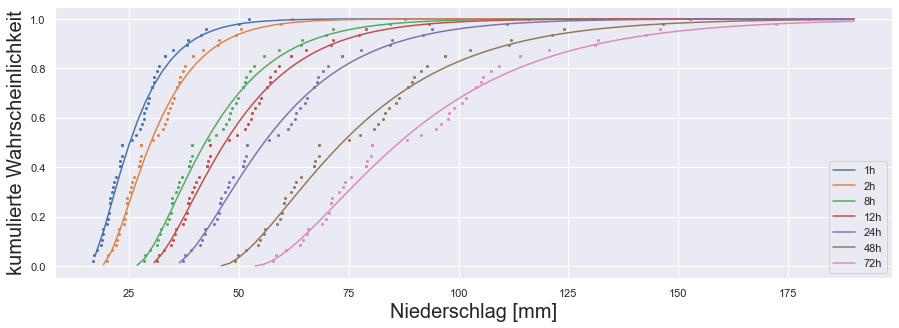

In [15]:
# fit parameters for each duration
parametersss = pd.DataFrame(index=['skew', 'loc', 'scale'], columns=annualMax.columns)
for duration in annualMax.columns:
    # fit the GEV and save the parameters
    parametersss[duration] = distr.pe3.lmom_fit(annualMax[duration]).values()
    
parametersss
# visualize the fit
I = np.linspace(start=0, stop=190, num=100)
for d in D: # for each storm duration
    plt.plot(I, pearson3(*parametersss[d]).cdf(I))
    plt.scatter(annualMax[d], ECDF(annualMax[d])(annualMax[d]), s=4, label=str(d) + ' min')
    #plt.xscale('log')
    #plt.grid(which='minor', alpha=0.8)
    #plt.xlim(10, 200)
plt.legend(['1h', '2h', '8h', '12h', '24h', '48h', '72h'], loc = 'lower right');
plt.xlabel('Niederschlag [mm]', fontsize = 20)
plt.ylabel('kumulierte Wahrscheinlichkeit', fontsize = 20)
#distr.pe3.lmom_fit(annualMax[duration]).values()
plt.savefig('a.png',dpi=300)

In [16]:
#return periiods
R = np.array([5, 10, 25, 50, 100], dtype="float64")
# non-exceedance probability
Pne = 1. - 1. / R

# rainfall intensity
I_2h = pearson3(*parametersss[24]).ppf(Pne) # ppf: percent point function

print('Rainfall intensity in 24 h storms at different return periods:')
for i, Tr in enumerate(R):
     print('I(Tr=', int(Tr), ') = ', round(I_2h[i], 1), ' mm', sep='')

Rainfall intensity in 24 h storms at different return periods:
I(Tr=5) = 73.2 mm
I(Tr=10) = 85.2 mm
I(Tr=25) = 100.2 mm
I(Tr=50) = 111.3 mm
I(Tr=100) = 122.2 mm


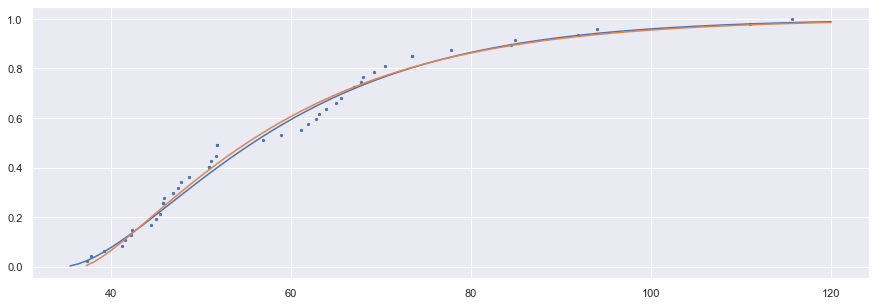

In [17]:
ecdf_24h = ECDF(annualMax_24h)
# visualize the fit
I = np.linspace(start=30, stop=120, num=100)
plt.plot(I, pearson3(**parasi).cdf(I))
plt.plot(I, pearson3(*parGEV_2h).cdf(I))
plt.scatter(annualMax_24h, ecdf_24h(annualMax_24h), s=5);


In [18]:
# NS-höhe_Tabelle mit Jährlichkeiten je Dauerstufe
IDFe = pd.DataFrame(index=R, columns=D)
IDFe.index.name = 'Tr'
for duration in D:
    IDFe[duration] = pearson3(*parametersss[duration]).ppf(Pne)

IDFe


,1,2,8,12,24,48,72
Tr,,,,,,,
5.00,33.07,39.33,55.62,61.55,73.20,96.58,113.59
10.00,38.48,45.76,64.71,71.61,85.16,112.37,132.16
25.00,45.29,53.86,76.17,84.29,100.24,132.27,155.56
50.00,50.29,59.80,84.57,93.59,111.30,146.86,172.72
100.00,55.19,65.63,92.82,102.72,122.16,161.19,189.57


0 5.0
1 10.0
2 25.0
3 50.0
4 100.0


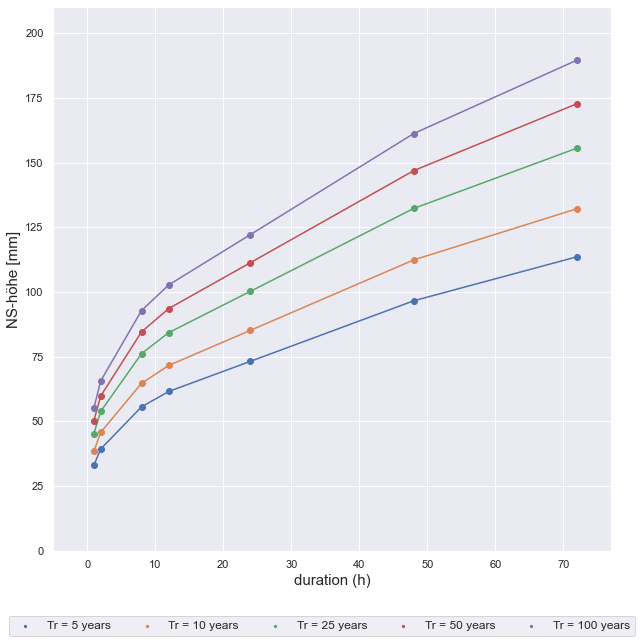

In [19]:
#Grafik dauer Häufigkeit...nicht vrewendet
fig = plt.figure(figsize=(10, 10))

plt.xlabel('duration (h)', fontsize=15)
plt.xlim(-5, D.max()+5)
#plt.xlim(0, IDFe.columns.max() + 5)
plt.ylabel('NS-höhe [mm]', fontsize=15)
plt.ylim((0, 210))

for i, Tr in enumerate(R):
    print(i, Tr)
    plt.scatter(D, IDFe.loc[Tr,:], s=5, label='Tr = ' + str(int(Tr)) + ' years')
    plt.plot(D, IDFe.loc[Tr,:],"o-")
#plt.xscale('log')

fig.legend(loc=8, ncol=6, fontsize=12);



In [20]:
#KS-Test
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)   
P0   = (N-1.)/Nmax
P    = np.delete(P0,0)

obs = sorted(df)[1:]

# extreme precipitations
gevSTo =  stats.genextreme.ppf(P, c=-0.11075177486598492,
                                   loc=51.253343718016865, scale=12.740797218611533)
pe3STo = stats.pearson3.ppf(P,skew=1.464578981137226,
                                   loc=60.16408510638298, scale=18.731024511582824)
#gumbel = stats.genextreme.ppf(P,c=-0.2121,
 #                                  loc=50.7974, scale=11.5985)


# do ks test
ks = [('GEV', stats.kstest(obs, gevSTo)),('PE3', stats.kstest(obs, pe3STo))]
      #('GUM', stats.kstest(obs, gumbel))]#, ('WEI', stats.ks_2samp(obs, weiSTo)),
      #('GPA', stats.ks_2samp(obs, gpaSTo)), ('PE3', stats.ks_2samp(obs, pe3STo)), 
      #('GAM', stats.ks_2samp(obs, gamSTo)), ('GLO', stats.ks_2samp(obs, gloSTo))]

labels = ['Verteilung', 'KS (statistics, pvalue)']
pd.DataFrame(ks, columns=labels)

,Verteilung,"KS (statistics, pvalue)"
0,GEV,"(0.10869565217391304, 0.9523375987514608)"
1,PE3,"(0.08695652173913043, 0.995862711499646)"


In [21]:
def IDF_type_I(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type I:
    
    I = (a * R + b) / (D + c)**d
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = (a * x[0] + b) / (x[1] + c)**d
    
    return I

def IDF_type_II(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type II:
    
    I = (a * R + b) / (D**c + d)   
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = (a * x[0] + b) / (x[1]**c + d)
    
    return I

def IDF_type_III(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type III:
    
    I = a * R**b / (D + c)**d
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = a * x[0]**b  / (x[1] + c)**d
    
    return I

def IDF_type_IV(x, a, b, c, d):
    """Estimate precipitation intensity given a return period and a storm duration using the analytical IDF curve type IV:
    
    I = a * R**b / (D**c + d).    
    
    Input:
    ------
    x:         list or array (2, 1). Values of return period (years) and duration (h)
    a:         float. Parameter of the IDF curve
    b:         float. Parameter of the IDF curve
    c:         float. Parameter of the IDF curve
    d:         float. Parameter of the IDF curve
    
    Output:
    -------
    I:         float. Precipitation intensity (mm/h)"""
    
    I = (a * x[0]**b) / (x[1]**c + d)
    
    return I

In [22]:
from scipy.optimize import curve_fit

# 1D array of intensity for each pair of values in 'R' and 'D'
I = np.empty((0))
for d in D:
    I = np.concatenate((I, IDFe[d]))
print(I.shape)
I

# grid with all possible combinations of duration and return period
(RR, DD) = np.meshgrid(R, D)
RR.shape, DD.shape

# convert the grid ('RR' and 'DD') into a 1D array
RR = RR.reshape(-1)
DD = DD.reshape(-1)
RR.shape, DD.shape


# join 'RR' and 'DD' as columns of a 2D array
RD = np.vstack([RR, DD])
RD.shape
# set type of curve
curve = IDF_type_IV
RD
# fit the curve
parIDF, pcov = curve_fit(curve, RD, I)

print('Fitted parameters of the analytical IDF')
for i, par in enumerate(['a', 'b', 'c', 'd']):
    print(par, '=', round(parIDF[i], 40))
    

(35,)
Fitted parameters of the analytical IDF
a = 13.278107621036092
b = 0.1659051446756954
c = -0.10077923750019825
d = -0.5014090808687319


In [23]:
# save the optimized parameters
IDFa = pd.DataFrame(parIDF, index=['a', 'b', 'c', 'd']).transpose()
IDFa
# export results
#IDFa.to_csv('../output/Ex5_Parameters analytical IDF.csv', float_format='%.5f')

,a,b,c,d
0,13.28,0.17,-0.10,-0.50


<ipython-input-24-70e3d765f56c>:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(-5, D.max()+5)


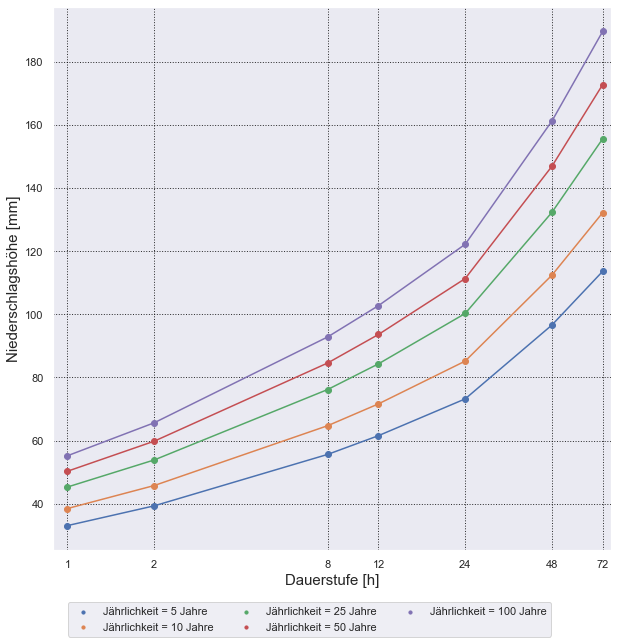

In [24]:
# erstelle Grafik Dauer Häufigkeit logarithmiiert
from matplotlib.ticker import ScalarFormatter
values = [1, 2, 8, 12, 24, 48, 72]
fig,ax = plt.subplots(figsize=(10, 10))
ax = plt.axes(xscale='log')
for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.xlim(-5, D.max()+5)
plt.xlabel('Dauerstufe [h]', fontsize=15)
plt.ylabel('Niederschlagshöhe [mm]', fontsize=15)
plt.grid(which='major', alpha=0.8, color = 'black', linestyle=':')
plt.xticks(values)
#plt.title('Diagramm', fontsize = 20)
#color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen', 'darkgreen']color=color[i]

D_ = np.linspace(1, 75, 10)

for i, Tr in enumerate(R):
    R_ = np.ones_like(D_) * Tr
    I_ = curve((R_, D_), *parIDF)

    plt.scatter(D, IDFe.loc[Tr,:], s=10, label='Jährlichkeit = ' + str(int(Tr)) + ' Jahre')
    plt.plot(D, IDFe.loc[Tr,:],"o-")
    #plt.plot(D_, I_);
    
fig.legend(loc=8, ncol=3)
    
# save figure
plt.savefig('J.png', dpi=300)